# Description
The first part is the same as Deberta, if you have any question please refer back to deverta-v3-base.ipynb.

In [ ]:
!pip install evaluate
! pip install torchinfo
!pip install datasets
! pip install peft

In [6]:
# AutoModelForSequenceClassification is adding a classification head on top of the pretrained model.
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
import evaluate
import numpy as np
import os
import json
# use the EvalPrediction as in the trainer class's compute_metrics parameter.
from transformers import EvalPrediction
# to calculate the cross entropy
import torch.nn.functional as F
# construct training arguments, for now I am just changing  batch-size, number of epochs, learning rate, scheduler.
from transformers import get_scheduler
from torch.optim import AdamW

from torchinfo import summary
from peft import LoraConfig, get_peft_model

import pandas as pd
import matplotlib.pyplot as plt

In [1]:
# input [1]
MODEL_NAME = "microsoft/deberta-v3-base"
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 2
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,use_fast=False)

# input [2]
datasets = load_dataset("nyu-mll/glue", "mrpc")
# tokenize the entire dataset: I make sure we pad every sentence (pair) to token length of 102
# I first use tokenizer() to tokenize the entire train,test,val set separately, and see that the maximum length of tokens is 102.
def tokenize(sample):
    tokenized_dataset = tokenizer(
        sample['sentence1'],
        sample['sentence2'],
        truncation=True,               # Truncate sequences longer than the model's max length
        padding='max_length',          # Pad to the maximum length
        max_length = 102,              # I tried to pad them separately and see that the max length of token is 102
        return_token_type_ids=True,    # Return token type IDs
        return_attention_mask=True,    # Return attention mask
    )
    return tokenized_dataset

tokenized_datasets = datasets.map(tokenize, batched =True)
tokenized_datasets = tokenized_datasets.remove_columns(['sentence1','sentence2','idx'])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# input [3]
TRAIN_VAL_STAGE = 'train_and_validate'
TEST_STAGE = 'test'
metric = evaluate.load("accuracy",)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return metric.compute(predictions=preds, references=p.label_ids)

def construct_epoch_dir(output_dir, epoch):
    epoch_dir = os.path.join(output_dir, f'epoch={epoch}')
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)
    return epoch_dir

def construct_metrics_record_filename(epoch_dir, stage):
    json_file = os.path.join(epoch_dir,f'{stage}_metrics.json')
    return json_file

def record_config(output_dir, hyper_parameters):
    # record the hyper parameters (dictionary)
    hyper_parameters_file = os.path.join(output_dir, 'hyper_parameters.json')
    with open(hyper_parameters_file, 'w') as f:
        json.dump(hyper_parameters, f)

def record_metrics(output_dir, epoch, records, stage=TRAIN_VAL_STAGE):
    epoch_dir = construct_epoch_dir(output_dir, epoch)
    json_file = construct_metrics_record_filename(epoch_dir, stage)
    with open(json_file, 'w') as f:
        json.dump(records, f, indent=4)
    return epoch_dir

def record_epoch_train_results(model, output_dir, epoch, records):
    # stage is automaticall train and validate
    epoch_dir = record_metrics(output_dir, epoch, records)
    model.save_pretrained(epoch_dir)
def evaluate_model(model, dataloaders, device, subsample_size=408, evaluate_set='validation'):
    '''evaluate means validate or test'''
    # set model to eval mode
    model.eval()
    # calculate number of samples being evaluated
    total_validated_samples = 0
    # calculate total loss and total number of correct labels (weighted acuracy)
    total_loss = 0
    total_accurate = 0
    # turn off grad computation
    with torch.no_grad():
        # evaluate batch by batch
        for step, batch in enumerate(dataloaders[evaluate_set]):
            # get the size of this batch
            batch_size = batch['labels'].shape[0]
            # forward pass in the model
            batch =  {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            # add loss to total loss
            loss = F.cross_entropy(input=outputs.logits, target=batch['labels'])
            total_loss += loss.item()
            # add weighted accuracy to total accuracy
            pred_and_tags = EvalPrediction(predictions=outputs.logits.detach().cpu().numpy(), label_ids=batch['labels'])
            accuracy = compute_metrics(pred_and_tags)['accuracy']
            total_accurate += accuracy * batch_size
            # add batch size to total number of validated samples
            total_validated_samples += batch_size
            # terminate the process if we are subsampling
            if total_validated_samples > subsample_size:
                break

    # calculate the loss and accuracy
    average_loss = total_loss/total_validated_samples
    average_accuracy = total_accurate/total_validated_samples
    return average_loss, average_accuracy

def train_epoch(model, epoch, dataloaders, device, optimizer, scheduler):
    records = []
    for step, batch in enumerate(dataloaders['train']):
        # put everything on the right device
        batch =  {k: v.to(device) for k, v in batch.items()}
        # clear gradients, same old as usual
        optimizer.zero_grad()
        # the batch already includes the 'labels' (y) and the input_ids, masks, input_type_ids (x).
        outputs = model(**batch)
        # outputs.loss might be problematic because of the NllLossBackward0 without softmax, should use nn.CrossEntropy
        loss = F.cross_entropy(input=outputs.logits, target=batch['labels'])
        loss.backward()
        # back propagation
        optimizer.step()
        # scheduler adjust lr
        scheduler.step()
        # record the train loss and accuracy
        pred_and_tags = EvalPrediction(predictions=outputs.logits.detach().cpu().numpy(), label_ids=batch['labels'])
        record = {"epoch":epoch, "batch":step, "train_loss":loss.item(), "train_accuracy":compute_metrics(pred_and_tags)['accuracy']}
        # validate the model
        val_loss, val_accuracy = evaluate_model(model, dataloaders, device, subsample_size=100)
        record.update({"val_loss": val_loss, 'val_accuracy': val_accuracy, 'val_subsample_size': 100})
        print(record)
        # append record to the output
        records.append(record)
    return model, records

def train_model(model, tokenized_datasets, hyper_parameters, output_dir):
    # batch size: the name is a bit weird because TrainingArguments can do it on multiple GPUs
    per_device_train_batch_size = hyper_parameters['per_device_train_batch_size']
    # initialize dataloaders
    dataloaders = {}
    dataloaders['train'] = DataLoader(tokenized_datasets['train'], batch_size=per_device_train_batch_size, shuffle=True)
    dataloaders['test'] = DataLoader(tokenized_datasets['test'], batch_size=per_device_train_batch_size)
    dataloaders['validation'] = DataLoader(tokenized_datasets['validation'], batch_size=per_device_train_batch_size, shuffle=True) # shuffle because we want to subsample

    # initialize optimizer
    learning_rate = hyper_parameters['learning_rate']
    optimizer = AdamW(model.parameters(),lr=learning_rate)  # Here `model` is assumed to be instantiated

    # scheduler
    lr_scheduler_type = hyper_parameters['lr_scheduler_type']
    lr_scheduler_kwargs = { 'optimizer':optimizer, **hyper_parameters['lr_scheduler_kwargs']}
    scheduler = get_scheduler(lr_scheduler_type, **lr_scheduler_kwargs)

    # number of epochs
    num_train_epochs = hyper_parameters['num_train_epochs']

    # Create the subdirectory for the hyperparameters: this directory is where we will save the result of trainning
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # WRITE hyperparameter to subdirectory
    record_config(output_dir, hyper_parameters)

    # get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # train the model on the hyper parameters
    for epoch in range(num_train_epochs):
        mdoel, records = train_epoch(model, epoch, dataloaders, device, optimizer, scheduler)
        # WRITE: save the result for this epoch
        record_epoch_train_results(model, output_dir, epoch, records)

        # at the end of each epoch, evaluate the model with full size
        val_loss, val_accuracy = evaluate_model(model, dataloaders, device)
        test_loss, test_accuracy = evaluate_model(model, dataloaders, device, subsample_size=1725, evaluate_set='test')

        # update the last time record: validate with full sample
        last_record = records.pop()
        last_record.update({"val_loss": val_loss, 'val_accuracy': val_accuracy, 'val_subsample_size': 408,
                            'test_loss':test_loss,  'test_accuracy': test_accuracy, 'test_subsample_size':1725})
        # WRITE test result to subdirectory
        record_metrics(output_dir, epoch, last_record, stage=TEST_STAGE)
        print(last_record)



/Users/samyiin/Projects/ParaphraseAnalysis/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Examples Looking at layers of the model

In [7]:
# load the model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

# Summarize the model
print(model)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [8]:
# Define LoRA configuration
lora_config = LoraConfig(
    task_type="classification",
    r=4,
    # include all the linear layers, not include 'word_embeddings' and all the fully connected layers
    target_modules=['query_proj', 'key_proj', 'value_proj'],
    # Include the final classification head: No need for dropout layer
    modules_to_save=['classifier', 'pooler']
)

lora_model = get_peft_model(model, lora_config)
# setting depth=5 to see the bigger picture model
summary(lora_model, (1, 102), dtypes=['torch.IntTensor'],depth=5,)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Layer (type:depth-idx)                                                      Output Shape              Param #
PeftModel                                                                   [1, 2]                    --
├─LoraModel: 1-1                                                            --                        --
│    └─DebertaV2ForSequenceClassification: 2-1                              [1, 2]                    --
│    │    └─DebertaV2Model: 3-1                                             [1, 102, 768]             --
│    │    │    └─DebertaV2Embeddings: 4-1                                   [1, 102, 768]             --
│    │    │    │    └─Embedding: 5-1                                        [1, 102, 768]             (98,380,800)
│    │    │    │    └─LayerNorm: 5-2                                        [1, 102, 768]             (1,536)
│    │    │    │    └─StableDropout: 5-3                                    [1, 102, 768]             --
│    │    │    └─DebertaV2Encoder: 

# Run: add LoRA to the model and run
This part include taking the hyper parameter and Configurate LoRA to get the LoRA model

In [ ]:
# defining best hyper parameters
per_device_train_batch_size = 16
learning_rate = 5e-04
num_train_epochs = 4

# calculate the arguments for shceduler: it depends on the sample size, batch size and epochs
train_sample_size = len(tokenized_datasets['train'])
# Here what I fixed is the warm up steps percentage=10%, so the warm up steps will be depend on num_epochs
num_training_steps = int((train_sample_size/per_device_train_batch_size) * num_train_epochs)
num_warmup_steps = int(0.1 * num_training_steps)

# define the best hyper parameter
hyper_parameters = {
            'learning_rate': learning_rate,
            'per_device_train_batch_size': per_device_train_batch_size,
            'lr_scheduler_type': 'linear',
            'num_train_epochs': num_train_epochs,
            'lr_scheduler_kwargs': {'num_warmup_steps':num_warmup_steps,
                                    'num_training_steps':num_training_steps},
        }

In [ ]:
google_drive_path = '/content/drive/MyDrive/Projects/ParaphraseAnalysis'
base_dir =  os.path.join(google_drive_path, 'LoRA_deberta_output/')
# Create the base directory if it doesn't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

for r in [4, 8, 32]:
    # Define LoRA configuration
    lora_config = LoraConfig(
        task_type="classification",
        r=r,
        # include all the linear layers, not include 'word_embeddings' and all the fully connected layers
        target_modules=['query_proj', 'key_proj', 'value_proj'],
        # Include the final classification head: No need for dropout layer
        modules_to_save=['classifier', 'pooler']
    )

    # get a fresh model for each experiment MODEL_NAME defined above
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

    lora_model = get_peft_model(model, lora_config)
    output_dir = os.path.join(base_dir, f'r={r}_epoch={num_train_epochs}_batch={per_device_train_batch_size}_lr={learning_rate}')

    train_model(lora_model, tokenized_datasets, hyper_parameters, output_dir)

# Results
This part is also the same as deberta, so I will not document here. 

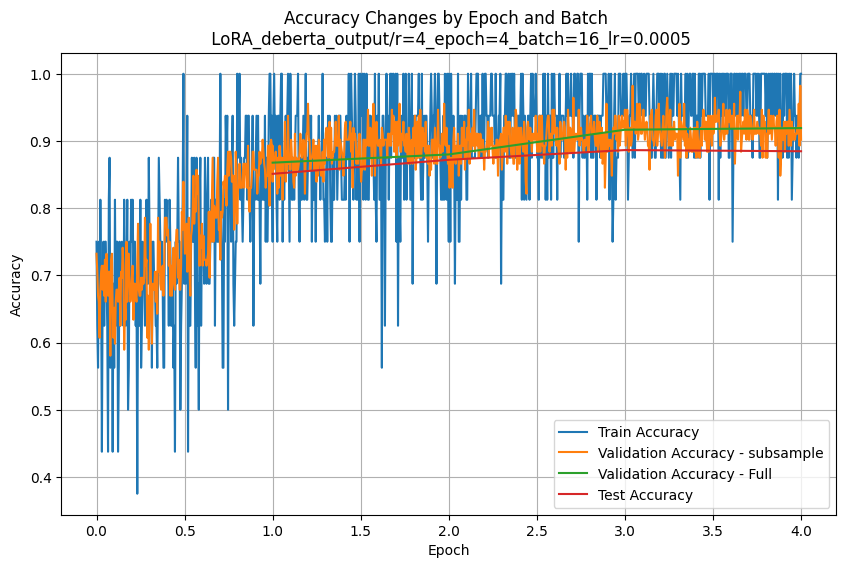

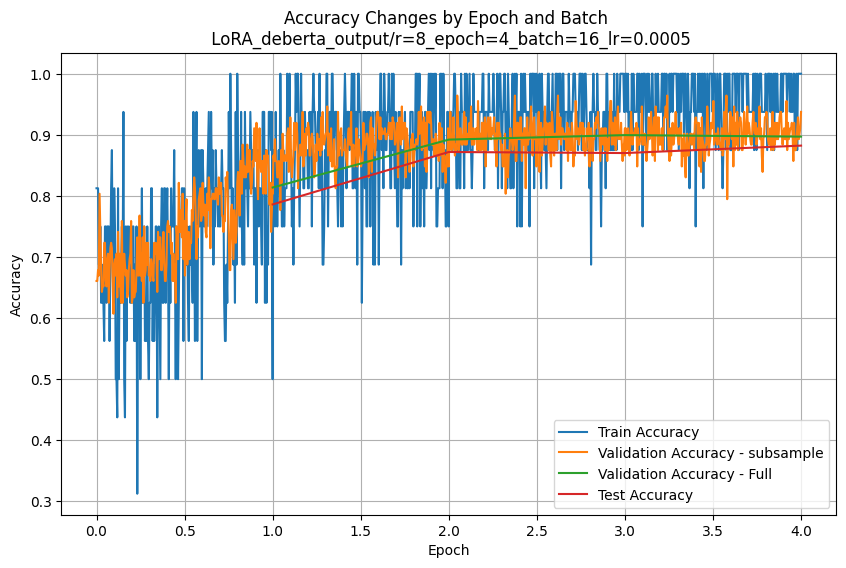

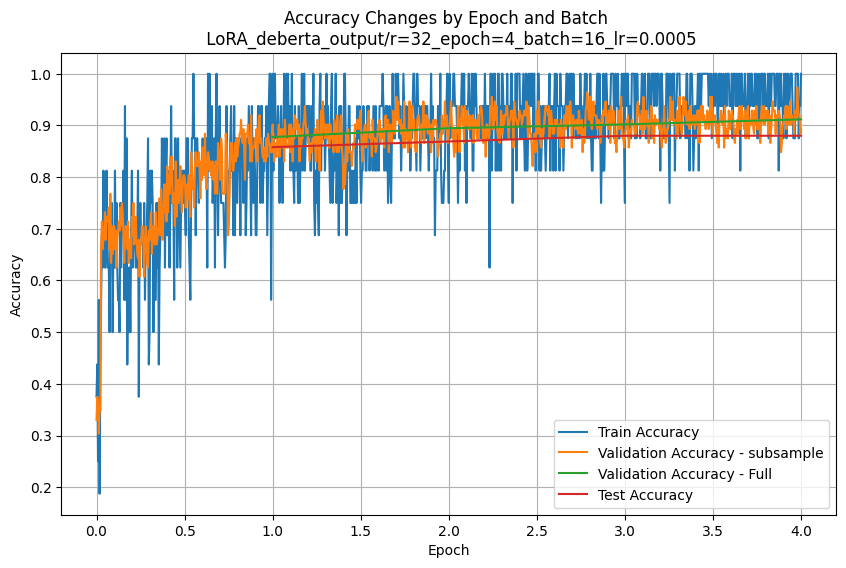

In [5]:
base_dir = 'LoRA_deberta_output/'
output_dir_list = []
for r in [4, 8, 32]:
    output_dir = f"r={r}_epoch=4_batch=16_lr=0.0005"
    output_dir = os.path.join(base_dir, output_dir)
    output_dir_list.append(output_dir)

all_train_results = []
all_test_results = []
num_train_epochs = 4
for output_dir in output_dir_list:
    all_epoch_train_results = []
    all_epoch_test_results = []
    # get all results
    for epoch in range(num_train_epochs):
        # construct each epoch's directory under subdirectory
        epoch_dir = construct_epoch_dir(output_dir, epoch)
        # combine all train results
        train_result_file = construct_metrics_record_filename(epoch_dir, stage=TRAIN_VAL_STAGE)
        with open(train_result_file, 'r') as f:
            epoch_train_result = json.load(f)
        all_epoch_train_results.extend(epoch_train_result)
        # also get all the test results
        test_result_file = construct_metrics_record_filename(epoch_dir, stage=TEST_STAGE)
        with open(test_result_file, 'r') as f:
            epoch_test_result = json.load(f)
        all_epoch_test_results.append(epoch_test_result)

    
        
    # put all results as a list of tuples
    all_train_results.append((f"{output_dir}", pd.DataFrame(all_epoch_train_results)))
    all_test_results.append((f"{output_dir}", pd.DataFrame(all_epoch_test_results)))

def plot_result(plt, df, list_target_columns, list_target_columns_ledgends):
    # make the x axis continuous throughout time
    df['epoch_batch'] = df['epoch'] + df['batch'] / (df['batch'].max())
    for target_column, ledgend in zip(list_target_columns, list_target_columns_ledgends):
        plt.plot(df['epoch_batch'], df[target_column], label=ledgend)
    return plt

for (hyper_param_str_train, df_train), (hyper_param_str_eval, df_eval) in zip(all_train_results, all_test_results):
    # Plotting
    plt.figure(figsize=(10, 6))

    # hyper_param_str_train and hyper_param_str_eval are the same
    plot_title = f'Accuracy Changes by Epoch and Batch \n {hyper_param_str_train}'
    y_label = "Accuracy"

    # first plot the train result
    list_target_columns = ['train_accuracy', 'val_accuracy']
    list_target_columns_ledgends = ['Train Accuracy', 'Validation Accuracy - subsample']
    plt = plot_result(plt, df_train, list_target_columns, list_target_columns_ledgends)

    # then plot the test result
    list_target_columns = ['val_accuracy', 'test_accuracy']
    list_target_columns_ledgends = ['Validation Accuracy - Full', 'Test Accuracy']
    plt = plot_result(plt, df_eval, list_target_columns, list_target_columns_ledgends)
    
    # set basic informations
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()
